# Resolução de Redes em python

Giovanna de Freitas Velasco - 1367634
João Pedro Gomes - 13839069

### Exercício A

Importar bibliotecas que serão usadas durante o exercício

In [37]:
import numpy as np
import matplotlib.pyplot as plt

Criar função `GeraMatriz` para gerar a matriz de condutâncias de uma rede hidráulica.

In [38]:
# Gera matriz de condutâncias
# nv: número de vértices
# nc: número de canos
# C: lista de condutâncias do cano
# connec: matriz de connecções
def GeraMatriz(nv, nc, C, conec):
    # Gera matriz de condutâncias, inicialmente nula
    A = np.zeros([nv, nv])

    # iterar sobre índices de cano 
    for i_cano in range(nc):
        # condutancia do i-ésimo cano
        cond_cano = C[i_cano]
        # "nós" nos quais há conexão do cano
        p, q = conec[i_cano]
        # matriz 2x2 de condutâncias locais entre nó p e nó q
        c_local = np.array([
            [cond_cano, -cond_cano], 
            [-cond_cano, cond_cano]
        ])
        # "somar" a matriz c_local na linha p, coluna q da matriz de condutâncias
        A[p, p] += c_local[0,0]
        A[p, q] += c_local[0,1]
        A[q, p] += c_local[1,0]
        A[q, q] += c_local[1,1]
    
    return A

Declarar função `ResolveRedes1`, para resolver redes nas quais um vértice está com pressão no nível da atmosfera e outro recebe uma vazão constante $QB$ utilizando a parte de álgebra linear da biblioteca NumPy

In [39]:
# Função que resolve uma rede tal que :
## um dos vertices nAtm está conectado à atmosfera
## outro nó nB recebe uma vazão QB

def ResolveRedes1(nv, nc, C, conec, nAtm, nB, QB):
    A = GeraMatriz(nv, nc, C, conec)
    
    # cópia da matriz A para a nova matriz NovaA
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    # a vazão no ponto B é igual a Qb
    Soma_cond = np.zeros(nv, dtype = float)
    Soma_cond[nB] = QB

    # a pressão em nAtm é igual a zero
    NovaA[nAtm, :] = 0.0
    NovaA[nAtm, nAtm] = 1.0

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure


A função `ResolveRede2`, de forma similar, resolve redes onde um nó tem pressão fixa e canos têm perdas de pressão.

In [40]:
# função que resolve redes tal que:
## há uma pressão fixa Pf a um nó nf
## há um consumo pré-estabelecido nos demais canos

def ResolveRede2(nv, nc, C, conec, nf, Pf):
    A = GeraMatriz(nv, nc, C, conec)

    # cópia da matriz A para a nova matriz A
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    NovaA[nf,:] = 0.0
    NovaA[nf,nf] = 1.0

    # a vazão nos demais canos diminui proporcionalmente ao consumo
    Soma_cond = -0.1 * np.ones(nv, dtype=float)
    Soma_cond[nf] = Pf

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure

Definir função que gera automaticamente os parâmetros para uma rede quadrada, com $lin$ linhas e $col$ colunas de nós

In [41]:
#Função que cria uma Rede Hidraulica em grade quadrada
#lin: numero de linhas
#col: numero de colunas
#CH: condutância dos canos horizontais
#CV: condutância dos canos verticais
#retorna número de vértices, número de canos,
#lista de condutâncias, matriz de conecções
#e coordenadas dos vértices
def CriaRedeQuad(lin, col, CH, CV):
    #numero de vertices e arestas
    nv = lin * col
    nc = (lin - 1) * col + (col - 1) * lin # arestas verticais + horizontais
    
    #criação da matriz de coordenadas dos vértices
    cond = np.zeros(shape = (nv,2))
    
    #popular matriz de coordenadas
    for i in range (lin):
        for j in range (col):
            ig = i + j * lin
            cond[ig,0] = i
            cond[ig,1] = j
            
    #matriz de conexões e condutancia
    conec = np.zeros(shape = (nc,2), dtype = int)
    C = np.zeros(nc)
    
    #Popular condutâncias (canos horizontais)
    for j in range(col):
        for i in range(lin - 1):
            k = j*(lin - 1) + i
            conec[k,0] = j*lin + i
            conec[k,1] = j*lin + i+1
            C[k] = CH
            
    #Popular condutâncias (canos verticais)
    for i in range(lin):
        for j in range(col - 1):
            k = (lin - 1)*col + j*lin + i
            conec[k,0] = i + j*lin
            conec[k,1] = i + (j+1)*lin
            C[k] = CV

    return nv, nc, conec, C, cond

Para verificar a pressão em cada aresta da matriz, utilizamos a função PlotaPress1. Para exibir as pressões nas Redes do Tipo 1, escolhemos valores para uma rede 8x8 e plotamos o gráfico para dois cenários distintos.

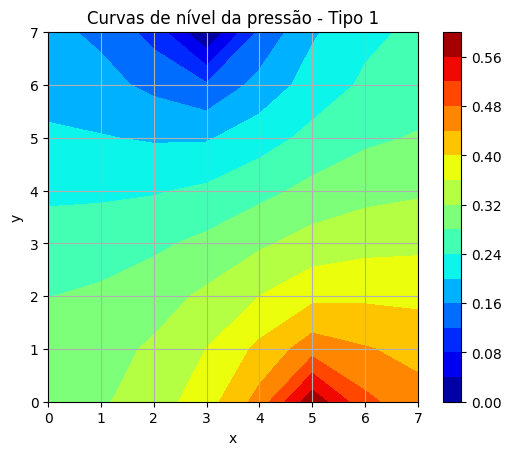

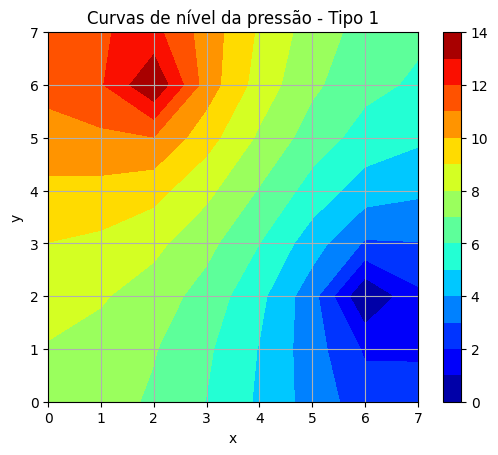

In [42]:
# Dados da rede proposta
col = 8
lin = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
natm = 3
nB = 12
QB = 2.7

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)


def PlotaPress1(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, lin, 1)
    y = np.arange(0, col, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (col ,lin)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de nível da pressão - Tipo 1')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, 15, cmap = 'jet')
    cb = plt.colorbar(cp)
    plt.show()


# Valores de teste para a Rede
natm = 59
nB = 5
QB = 1.2

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)

PlotaPress1(col, lin, pressure)


# Valores de teste para a Rede
natm = 22
nB = 50
QB = 34.5

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)

PlotaPress1(col, lin, pressure)

Realizamos o mesmo procedimento para uma Rede do Tipo 2.

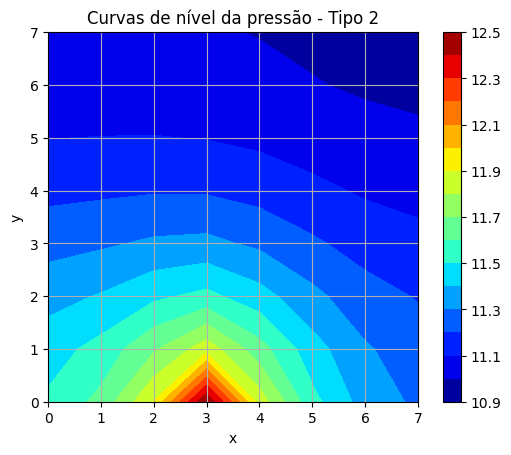

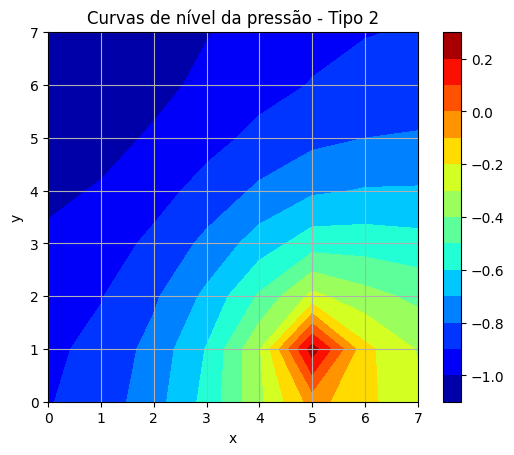

In [43]:
# Dados da rede proposta
col = 8
lin = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
nf = 3
Pf = 12.5

pressure, max_pressure = ResolveRede2(nv, nc, C, conec, nf, Pf)

def PlotaPress2(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, lin, 1)
    y = np.arange(0, col, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (col ,lin)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de nível da pressão - Tipo 2')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, 15, cmap = 'jet')
    cb = plt.colorbar(cp)
    plt.show()

PlotaPress2(col, lin, pressure)

# Valores de teste para a Rede
nf = 13
Pf = 0.25

pressure, max_pressure = ResolveRede2(nv, nc, C, conec, nf, Pf)
PlotaPress2(col, lin, pressure)

## Exercício B

Definição da função que retorna a matriz Q

In [44]:
def MatrizK(C):
#definição da matriz K
    K = np.zeros(shape = (nv,nc))
    for i in range (nv):
        for j in range(nc):
            if(i == j):
                K[i,j] = C[i]
    return K

def MatrizD(conec):
    D = np.zeros(shape = (nc,nv))
    for k in range (nc):
        p = conec[k,0]
        q = conec[k,1]
        for j in range(nv):
            if(j == p):
                D[k,j] = 1
            if(j == q):
                D[k,j] = -1
    return D


def RetornaVazao(conec, C, pressure):
    K = MatrizK(C)
    D = MatrizD(conec)

    # a matriz de condutancia é igual a multiplicação das matrizes 
    Co = K @ D

    # a vazão é igual a matriz de condutancias vezes o vetor de pressões
    Q = Co @ pressure
    return Q

Exemplo da matriz para Redes do Tipo 1

In [45]:
# Dados da rede proposta
col = 8
lin = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
natm = 3
nB = 12
QB = 2.7

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)
Q = RetornaVazao(conec, C, pressure)
print("Vazões para exemplo de Rede Tipo 1 :", Q)

Vazões para exemplo de Rede Tipo 1 : [ 6.34518973e-02  1.81398409e-01  5.03353784e-01 -1.08863071e+00
 -1.95286457e-01 -2.65017499e-02  3.76764650e-04  2.25809366e-02
  2.83917614e-02 -8.61913161e-02 -9.27627262e-01  3.48133200e-01
  7.99278945e-02  2.08182241e-02 -5.71244039e-03 -3.43194596e-02
 -1.30596765e-01 -3.29521123e-01  2.45271821e-02  2.95358129e-02
  1.25410986e-02 -1.68348833e-02 -4.62779657e-02 -9.80169246e-02
 -1.46144483e-01 -3.72990796e-02 -4.35375999e-03  9.23761473e-04
 -1.85011768e-02 -4.15145644e-02 -6.81456349e-02 -8.04975623e-02
 -4.22002789e-02 -1.74924842e-02 -6.04261347e-03 -1.67833121e-02
 -3.40379009e-02 -4.89837027e-02 -5.28375500e-02 -3.69093616e-02
 -2.06877656e-02 -8.95354545e-03 -1.47119899e-02 -2.82928278e-02
 -3.81407362e-02 -4.00140645e-02 -3.18385002e-02 -2.05175149e-02
 -9.77897144e-03 -1.34890315e-02 -2.53474520e-02 -3.32787046e-02
 -3.47272485e-02 -2.91267045e-02 -1.99104328e-02 -9.88471843e-03
 -6.34518973e-02 -1.17946512e-01 -3.21955375e-01 -1.1

Matriz Q para Redes Tipo 2

In [46]:
# Dados da rede proposta
col = 8
lin = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
nf = 3
Pf = 12.5

pressure, max_pressure = ResolveRede2(nv, nc, C, conec, nf, Pf)
Q = RetornaVazao(conec, C, pressure)
print("Vazões para exemplo de Rede Tipo 2: ", Q)

Vazões para exemplo de Rede Tipo 2:  [-3.39047961e-01 -8.21109124e-01 -1.79090728e+00  1.93379769e+00
  9.74685863e-01  5.18125339e-01  2.30894987e-01 -2.31788059e-01
 -4.55306376e-01 -5.11784631e-01  6.46660284e-01  5.97772387e-01
  3.91127710e-01  1.88643463e-01 -1.30730463e-01 -2.14783675e-01
 -1.43854357e-01  2.65022489e-01  3.39176498e-01  2.61009757e-01
  1.36011352e-01 -6.46808046e-02 -9.04978716e-02 -2.93847292e-02
  1.34426823e-01  1.94821170e-01  1.66015552e-01  9.16389509e-02
 -2.77789496e-02 -3.14097253e-02  8.06109108e-03  8.13940618e-02
  1.17365815e-01  1.05199586e-01  6.02133121e-02 -8.98822518e-03
 -4.64777310e-03  2.01102956e-02  5.63822131e-02  7.60139483e-02
  6.89986521e-02  4.02079520e-02 -1.94008650e-04  6.80096668e-03
  2.35241135e-02  4.38505012e-02  5.46473547e-02  4.91292713e-02
  2.87655308e-02  3.20846989e-03  1.09535778e-02  2.42355007e-02
  3.84659398e-02  4.55169638e-02  4.03941334e-02  2.36244523e-02
  2.39047961e-01  3.82061163e-01  8.69798160e-01  2.5

## Exercício C

Para realizar o cálculo da potência consumida, definimos a função Potência, que realiza a operação

$$ W = p^t (D^t K D) p $$

In [47]:
def Potencia(conec, C, pressure):
    K = MatrizK(C)
    D = MatrizD(conec)
    D_t = np.array(D).T
    p_t = np.array(pressure).T

    W = np.dot(np.dot(np.dot(np.dot(D_t, K), D), p_t), pressure)

    return W

In [50]:
# Dados da rede proposta
col = 8
lin = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
natm = 3
nB = 12
QB = 2.7

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)
Q = RetornaVazao(conec, C, pressure)
W = Potencia(conec, C, pressure)
print("Potencia consumida :", W)

ValueError: shapes (64,112) and (64,112) not aligned: 112 (dim 1) != 64 (dim 0)